In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import random
import torch
from openslide import OpenSlide
from torch.utils.data.dataset import Dataset
from torchvision import utils
from torchvision import transforms
import albumentations as A
import time

In [2]:
from matplotlib import pyplot as plt

In [3]:
DATA_DIR='data/prostate-cancer-grade-assessment'

In [4]:
# OpenSlideImage
class OpenSlideImage(object):
    def __init__(self, filepath):
        self.filepath = filepath
        self.instance = OpenSlide(filepath)

    def open(self, filepath):
        self.filepath = filepath
        self.instance = OpenSlide(filepath)

    def size(self):
        return self.instance.dimensions

    def level(self):
        return self.instance.level_count

    def get_size(self, level):
        return self.instance.level_dimensions[level]

    def load(self, level=0, rect=None):
        if rect is not None:
            p = (rect[0], rect[1])
            s = (rect[2], rect[3])
        else:
            p = (0, 0)
            s = self.get_size(level)
        return np.asarray(self.instance.read_region(p, level, s))

In [5]:
def Padding(img, patch, value):
    h, w = img.shape[:2]
    ph = (patch - (h % patch)) if h % patch > 0 else 0
    pw = (patch - (w % patch)) if w % patch > 0 else 0
    pshape = [[0, ph], [0, pw], [0, 0]] if len(img.shape) == 3 else [[0, ph], [0, pw]]
    return np.pad(img, pshape, constant_values=value)

In [6]:
def GetOpenSlide(df, idx):
    idn = df.iat[idx, 0]
    # if not os.path.exists(INFER_TARGET_IMGDIR):
    #     return None, idn
    # return OpenSlide(os.path.join(INFER_TARGET_IMGDIR, idn + '.tiff')), idn
    return OpenSlide(os.path.join(DATA_DIR, 'train_images', idn + '.tiff')), idn

In [7]:
def GetItemScale(osi, lv1, lv2):
    if osi is None:
        scale = 4.0
    else:
        scale = osi.level_downsamples[lv2] / osi.level_downsamples[lv1]
    return scale

In [8]:
def GetItemLv2(osi):
    # if osi is None or not os.path.exists(INFER_TARGET_IMGDIR):
    #     img = np.ones([256, 256, 3], dtype=np.uint8) * 255
    # else:
    #     img = np.asarray(osi.read_region((0, 0), 2, osi.level_dimensions[2]))[:, :, :3].astype(np.uint8)
    img = np.asarray(osi.read_region((0, 0), 2, osi.level_dimensions[2]))[:, :, :3].astype(np.uint8)
    return img

In [9]:
def GetItemLv1(osi):
    # if osi is None or not os.path.exists(INFER_TARGET_IMGDIR):
    #     img = np.ones([1024, 1024, 3], dtype=np.uint8) * 255
    # else:
    #     img = np.asarray(osi.read_region((0, 0), 1, osi.level_dimensions[2]))[:, :, :3].astype(np.uint8)
    img = np.asarray(osi.read_region((0, 0), 1, osi.level_dimensions[2]))[:, :, :3].astype(np.uint8)
    return img

In [10]:
def GetItemRectLv(osi, rect, level):
    if level == 0:
        return GetItemRectLv0(osi, rect)
    else:
        return GetItemRectLv1(osi, rect)

def GetItemRectLv1(osi, rect):
    # if osi is None or not os.path.exists(INFER_TARGET_IMGDIR):
    #     img = np.ones([1024, 1024, 3], dtype=np.uint8) * 255
    # else:
    max_x = osi.level_dimensions[1][0]
    max_y = osi.level_dimensions[1][1]
    ratio = osi.level_downsamples[1] / osi.level_downsamples[0]
    x0, y0, x1, y1 = rect
    xb = int(x0 * ratio)
    yb = int(y0 * ratio)
    px = 0
    py = 0
    if x1 > max_x:
        px = max_x - x1
        x1 = max_x
    if y1 > max_y:
        py = max_y - y1
        y1 = max_y
    dx = x1 - x0
    dy = y1 - y0
    img = np.asarray(osi.read_region((xb, yb), 1, (dx, dy)))[:, :, :3].astype(np.uint8)
    if px > 0 or py > 0:
        img = np.pad(img, [[0, py], [0, px], [0, 0]], constant_values=255)
    return img

def GetItemRectLv0(osi, rect):
    # if osi is None or not os.path.exists(INFER_TARGET_IMGDIR):
    #     img = np.ones([4096, 4096, 3], dtype=np.uint8) * 255
    # else:
    max_x = osi.level_dimensions[0][0]
    max_y = osi.level_dimensions[0][1]
    x0, y0, x1, y1 = rect
    px = 0
    py = 0
    if x1 > max_x:
        px = max_x - x1
        x1 = max_x
    if y1 > max_y:
        py = max_y - y1
        y1 = max_y
    dx = x1 - x0
    dy = y1 - y0
    img = np.asarray(osi.read_region((x0, y0), 0, (dx, dy)))[:, :, :3].astype(np.uint8)
    if px > 0 or py > 0:
        img = np.pad(img, [[0, py], [0, px], [0, 0]], constant_values=255)
    return img

In [11]:
tdf = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

In [12]:
IS = 2048
TS = 128
TR = 4
TC = 4
TN = TR * TC

In [13]:
osi, idn = GetOpenSlide(tdf, 0)
oss = GetItemScale(osi, 0, 2)
print('scale = {}'.format(oss))

scale = 16.0


In [14]:
st = time.time()

img2 = GetItemLv2(osi)
img2 = Padding(img2, TS, 255)
nh = img2.shape[0] // TS
nw = img2.shape[1] // TS

order = []
for hi in range(nh):
    for wi in range(nw):
        buf = img2[hi * TS:(hi + 1) * TS, wi * TS:(wi + 1) * TS, :].astype(np.int32)
        order.append((hi, wi, np.sum(buf)))
        order = sorted(order, key=lambda x: x[2])
if len(order) > TN:
    order = order[:TN]

img1 = np.ones([TR * IS, TC * IS, 3], dtype=np.uint8) * 255
iscl = oss * TS
for j, val in enumerate(order):
    r, c, _ = val
    rect = (
        int(iscl * (c)),
        int(iscl * (r)),
        int(iscl * (c+1)),
        int(iscl * (r+1))
    )
    buf = GetItemRectLv0(osi, rect)
    buf = cv2.resize(buf, (IS, IS))
    u, v = divmod(j, TC)
    img1[u * IS:(u+1) * IS, v * IS:(v+1)*IS, :] = buf

et = time.time()

In [15]:
print('{:3} sec'.format(et - st))

3.2147676944732666 sec


In [16]:
print(img1.shape)

(8192, 8192, 3)


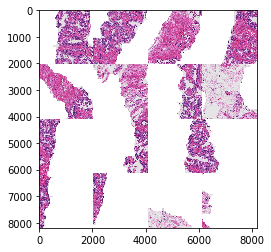

In [18]:
plt.imshow(img1)